**Write the names of all group members (max. 5 members)**:
- Ramon, Kaspar
- Cyrill, Stotz

When submitting your work, please follow closely the template below.

# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.

**Solution:**

We start with the fact that $ d S_t = r S_t dt + \sigma S_t dW_t$. Now we apply [Itô's Formula](https://planetmath.org/itosformula) to $\log(S_t)$:

$$ 
    \begin{align} 
    d \log(S_t) 
    \overset{\text{Itô's Formula}}{=} && \frac{1}{S_t} d S_t - \frac{1}{2} \sigma^2 dt && \\ 
    = && r d t + \sigma d W - \frac{1}{2} \sigma^2 dt && \\ 
    = && \sigma d W - \frac{1}{2} \sigma^2 dt && 
    \end{align}
 $$
 since $r=0$.

 Now we integrate both sides to get to:

 $$
    \begin{align}
    \log(S_t) = && \log(S_0) + \int_0^t \sigma d W - \frac{1}{2} \sigma^2 dt&& \\
    = && \log(S_0) + \int_0^t \sigma d W - \int_0^t \frac{1}{2} \sigma^2 dt && \\
    = && \log(S_0) + \sigma W_t - \frac{1}{2} \sigma^2 t &&
    \end{align}
 $$

 Now we can take the exponential of both sides to get to the solution:

 $$
    \begin{align}
    S_t = && \exp(\log(S_0) + \sigma W_t - \frac{1}{2} \sigma^2 t) && \\
    = && \exp(\log(S_0)) \exp(\sigma W_t - \frac{1}{2} \sigma^2 t) && \\
    = && S_0 \exp(\sigma W_t - \frac{1}{2} \sigma^2 t) &&
    \end{align}
$$


### Question 1.b - Generate dataset

In [12]:
import numpy as np
np.random.seed(69)  # for reproducibility

import matplotlib.pyplot as plt
import time

Training set shape: (1000000, 31)
Test set shape: (100000, 31)


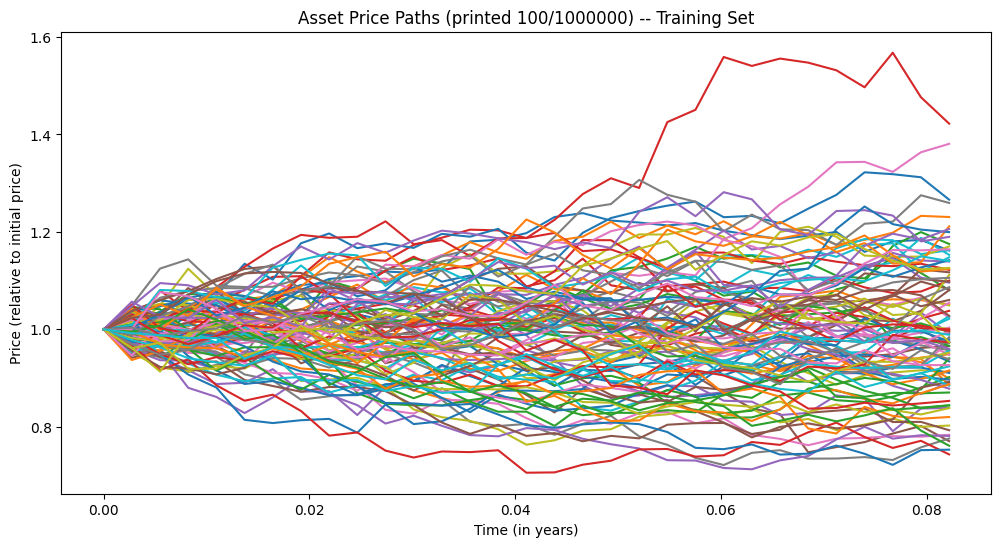

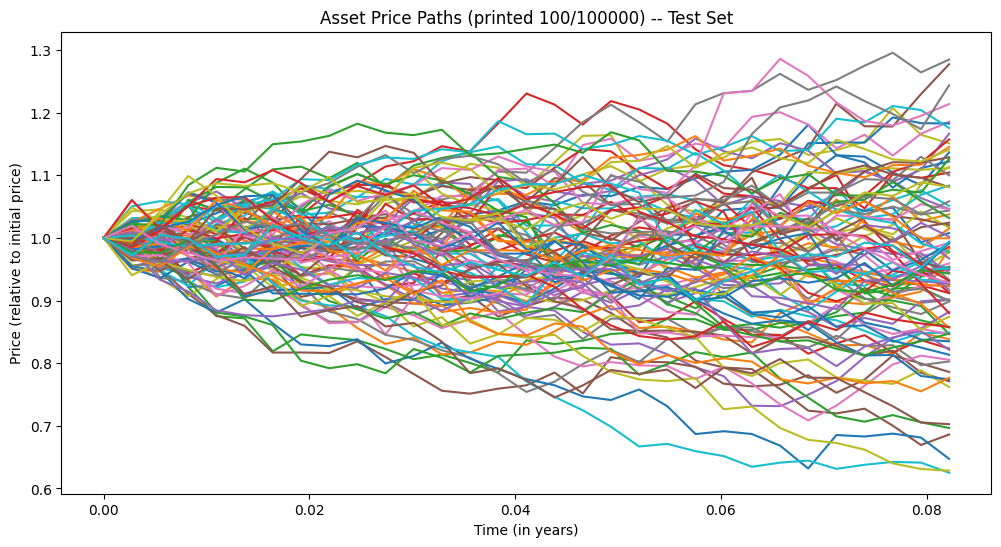

In [13]:
# Generate the training set

N = 30      # Periods
s_0 = 1.0   # Initial stock price
T = 30/365  # Time horizon, in years (so 1 month)
sigma = 0.5
r = 0.0     # Risk-free rate, 0 in our case
num_train = int(10e5)      # Num. training paths
num_test = int(10e4)       # Num. test paths

def simulate_price_of_asset(s0, sigma, N, n_paths):
    """ 
    Simulate the path of asset prices using the Brownian motion model.
    """
    # Matrix to store the paths
    S = np.zeros((n_paths, N + 1))
    # All assets start with the initial price
    S[:, 0] = s0  

    for i in range(N):
        # Z_i ~ N(0, 1)
        Z = np.random.randn(n_paths)
        # Calculate the price at the next time step
        S[:, i+1] = S[:, i] * np.exp(-sigma**2 * T / (2 * N) + sigma * np.sqrt(T / N) * Z)
    
    return S


S_train = simulate_price_of_asset(s_0, sigma, N, num_train)
S_test = simulate_price_of_asset(s_0, sigma, N, num_test)

print("Training set shape:", S_train.shape)
print("Test set shape:", S_test.shape)

SAMPLES = 100   # Number of paths we plot

# Plot training set
plt.figure(figsize=(12, 6))
for i in range(SAMPLES):
    plt.plot(np.linspace(0, T, N + 1), S_train[i], label=f'Path {i+1}')
plt.title(f'Asset Price Paths (printed {SAMPLES}/{num_train}) -- Training Set')
plt.xlabel('Time (in years)')
plt.ylabel('Price (relative to initial price)')
plt.savefig('plots/asset_price_paths.pdf')
plt.show()

# Plot test set
plt.figure(figsize=(12, 6))
for i in range(SAMPLES):
    plt.plot(np.linspace(0, T, N + 1), S_test[i])
plt.title(f'Asset Price Paths (printed {SAMPLES}/{num_test}) -- Test Set')
plt.xlabel('Time (in years)')
plt.ylabel('Price (relative to initial price)')
plt.show()

### Question 1.c - Model implementation

In [14]:
# Implement the deep hedging model
import torch
import torch.nn as nn

class HedgingNetwork(nn.Module):
    """A neural network that computed the hedging strategy at a given time step."""
    def __init__(self, num_features):
        super(HedgingNetwork, self).__init__()
        self.num_features = num_features
        self.neural_network = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.neural_network(x)
        

    
class DeepHedgingModel(nn.Module):
    """The deep hedging model, composed of number_of_time_steps hedging networks."""
    def __init__(self, number_of_time_steps, num_features):
        super(DeepHedgingModel, self).__init__()
        self.number_of_time_steps = number_of_time_steps
        # We create a hedging network for each time step
        # Use ModuleList to create a list of PyTorch modules (so we can track parameters)
        self.hedging_networks = nn.ModuleList([HedgingNetwork(num_features) for _ in range(number_of_time_steps)])
    
    def forward(self, S_paths):
        """
        Compute the hedging strategies for each time step.
        """
        H = []
        for j in range(self.number_of_time_steps):
            # Input is log(S_tj)
            log_S_tj = torch.log(S_paths[:, j]).unsqueeze(1)    # Shape: (num_paths, 1)
            H_j = self.hedging_networks[j](log_S_tj)
            H.append(H_j.squeeze(1))    # Shape: (num_paths,)
        # Stack the hedging strategies along the time dimension
        H = torch.stack(H, dim=1)   # Shape: (num_paths, number_of_time_steps)
        return H

### Question 1.d - Model training

In [15]:
# Implement the payoff function of a call option

def call_option_payoff(S_T, K):
    """
    Computes the payoff of a European call option.
    
    Parameters:
        S_T (torch.Tensor): Asset price at maturity
        K (float): Strike price
    """
    # Cannot have negative payoff
    return torch.max(S_T - K, torch.tensor(0.0))

In [16]:
# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity
from scipy.stats import norm    # normal distribution

def black_scholes_call_price(S_t, t, K, T, sigma, r=0) -> float:
    """
    Computes the Black-Scholes price for a European call option.

    Parameters:
        S_t (float): Current asset price
        t (float): Current time (in years)
        K (float): Strike price
        T (float): Time to maturity (in years)
        sigma (float): Volatility
        r (float): Risk-free interest rate. (we use 0)
    """
    d_plus = (1.0 / (sigma * np.sqrt(T - t))) * ((np.log(S_t / K) + (r + sigma ** 2 / 2.0) * (T - t)))
    d_minus = d_plus - sigma * np.sqrt(T - t)
    call_price = norm.cdf(d_plus) * S_t - norm.cdf(d_minus) * K * np.exp(-r * (T - t))
    return call_price

In [17]:
# Train the model
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

S_train_tensor = torch.from_numpy(S_train).float()  # Shape: (num_train, N+1)
S_test_tensor = torch.from_numpy(S_test).float()    # Shape: (num_test, N+1)
train_dataset = TensorDataset(S_train_tensor)
test_dataset = TensorDataset(S_test_tensor)

model = DeepHedgingModel(number_of_time_steps=N, num_features=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-3
milestones = [75]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
NUM_EPOCHS = 5
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)   
print(f"Training set tensor shape: {S_train_tensor.shape}")
print(f"Test set tensor shape: {S_test_tensor.shape}")

p = black_scholes_call_price(S_t=s_0, t=0, K=1, T=T, r=r, sigma=sigma)
print(f"Risk-neutral price p of the European call option: {p:.6f}")
p = torch.tensor(p).to(device)

Training set tensor shape: torch.Size([1000000, 31])
Test set tensor shape: torch.Size([100000, 31])
Risk-neutral price p of the European call option: 0.057138


100%|██████████| 5/5 [29:57<00:00, 359.58s/it, loss=8.42e-5] 


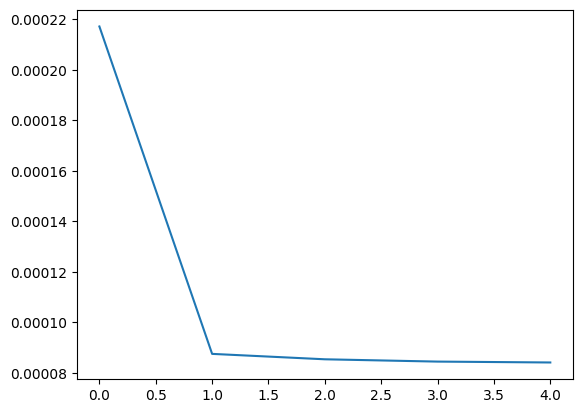

In [18]:

from tqdm import tqdm

# Training Loop
losses = []

start_time = time.time()

model.train()
training_loop = tqdm(range(NUM_EPOCHS)) 
for epoch in training_loop:
    epoch_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):    # Number of batches = num_train / BATCH_SIZE
        # print(f"Batch: {batch_idx+1}/{len(train_loader)}")
        S_batch = batch[0].to(device)  # Shape: (batch_size, N+1)
        
        # Forward pass: Compute hedging strategies H
        H = model(S_batch)  # Shape: (batch_size, N)
        
        # Compute delta_S: S_{t_{j+1}} - S_{t_j}
        delta_S = S_batch[:, 1:] - S_batch[:, :-1]
        
        # Compute hedging cost: sum_j H_{t_j} * delta_S_{t_j}
        hedging_cost = torch.sum(H * delta_S, dim=1)  # Shape: (batch_size,)
        
        # Compute the option payoff g(S_T) = max(S_T - K, 0)
        g_of_S_T = call_option_payoff(S_T=S_batch[:, -1], K=1)  # Shape: (batch_size,)
        
        # Compute hedging error (i.e., the loss)
        tmp = torch.square(g_of_S_T - p - hedging_cost)
        hedging_error = torch.mean(tmp)
        
        # Backward pass and optimization
        hedging_error.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Accumulate the loss
        epoch_loss += torch.sum(tmp).detach().item() 
    
    # decrease learning rate according to scheduler's settings
    scheduler.step()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / num_train
    losses.append(avg_epoch_loss)
    training_loop.set_postfix(loss = avg_epoch_loss)
    
training_time = time.time() - start_time
    
# Plot the training loss
plt.plot(losses, label='Training loss')
plt.show()

### Question 1.e - Model evaluation

Empirical Mean of Hedging Errors: -0.000012
Empirical Standard Deviation of Hedging Errors: 0.009144
Relative Standard Deviation (compared to option price): 0.160031


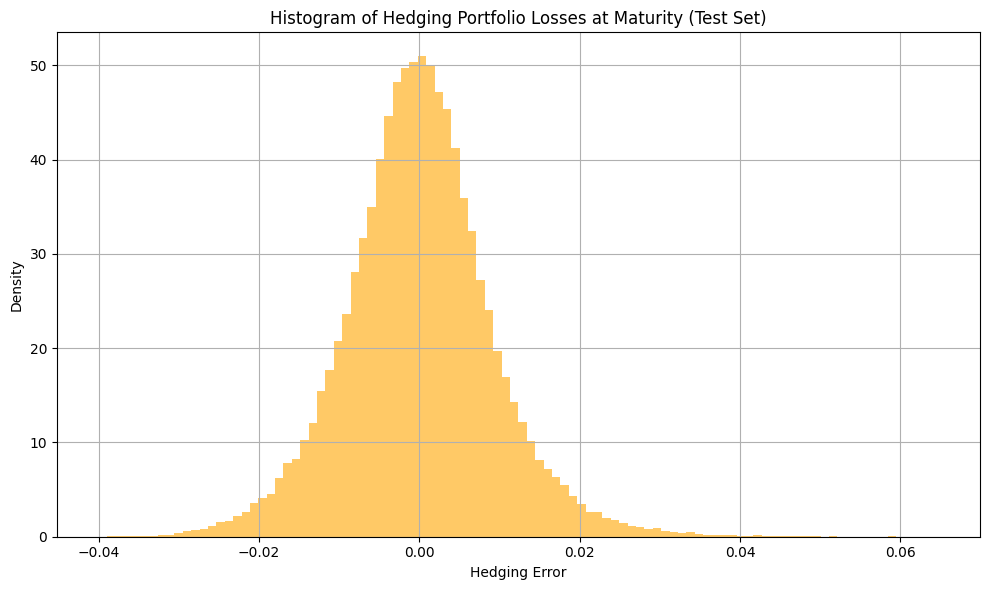

In [19]:
# Evaluate the hedging losses on the test set

model.eval()

with torch.no_grad():   # Disable gradient calculations
    hedging_errors = []
    
    for batch_idx, batch in enumerate(test_loader):
        # print(f"Batch: {batch_idx+1}/{len(train_loader)}")
        S_batch = batch[0].to(device)  # Shape: (batch_size, N+1)
        
        # Forward pass: Compute hedging strategies H
        H = model(S_batch)  # Shape: (batch_size, N)
        
        # Compute delta_S: S_{t_{j+1}} - S_{t_j}
        delta_S = S_batch[:, 1:] - S_batch[:, :-1]
        
        # Compute hedging cost: sum_j H_{t_j} * delta_S_{t_j}
        hedging_cost = torch.sum(H * delta_S, dim=1)  # Shape: (batch_size,)
        
        # Compute the option payoff g(S_T) = max(S_T - K, 0)
        g_of_S_T = call_option_payoff(S_T=S_batch[:, -1], K=1)  # Shape: (batch_size,)
        
        # Compute hedging error (i.e., the loss)
        hedging_error = g_of_S_T - p - hedging_cost
        hedging_errors.extend(hedging_error.detach().numpy())


# Plot a histogram of the hedging losses and print mean and standard deviation
mean_error = np.mean(hedging_errors)
std_error = np.std(hedging_errors)
relative_std = std_error / p

print(f"Empirical Mean of Hedging Errors: {mean_error:.6f}")
print(f"Empirical Standard Deviation of Hedging Errors: {std_error:.6f}")
print(f"Relative Standard Deviation (compared to option price): {relative_std:.6f}")

plt.figure(figsize=(10, 6))
plt.hist(hedging_errors, bins=100, density=True, alpha=0.6, color='orange')
plt.title(f'Histogram of Hedging Portfolio Losses at Maturity (Test Set)')
plt.xlabel('Hedging Error')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/histogram_hedging_errors.pdf')
plt.show()

**COMMENT**:
- The hedging error is very close to 0, so we conclude that the hedging strategy is unbiased.
- To judge whether the standard deviation is sufficiently small, we  compare it to the option price $p$, which yields a relative standard deviation of $\approx 16.0\%$. This means that the hedging error is within $\pm 16.0\%$ of the option price.

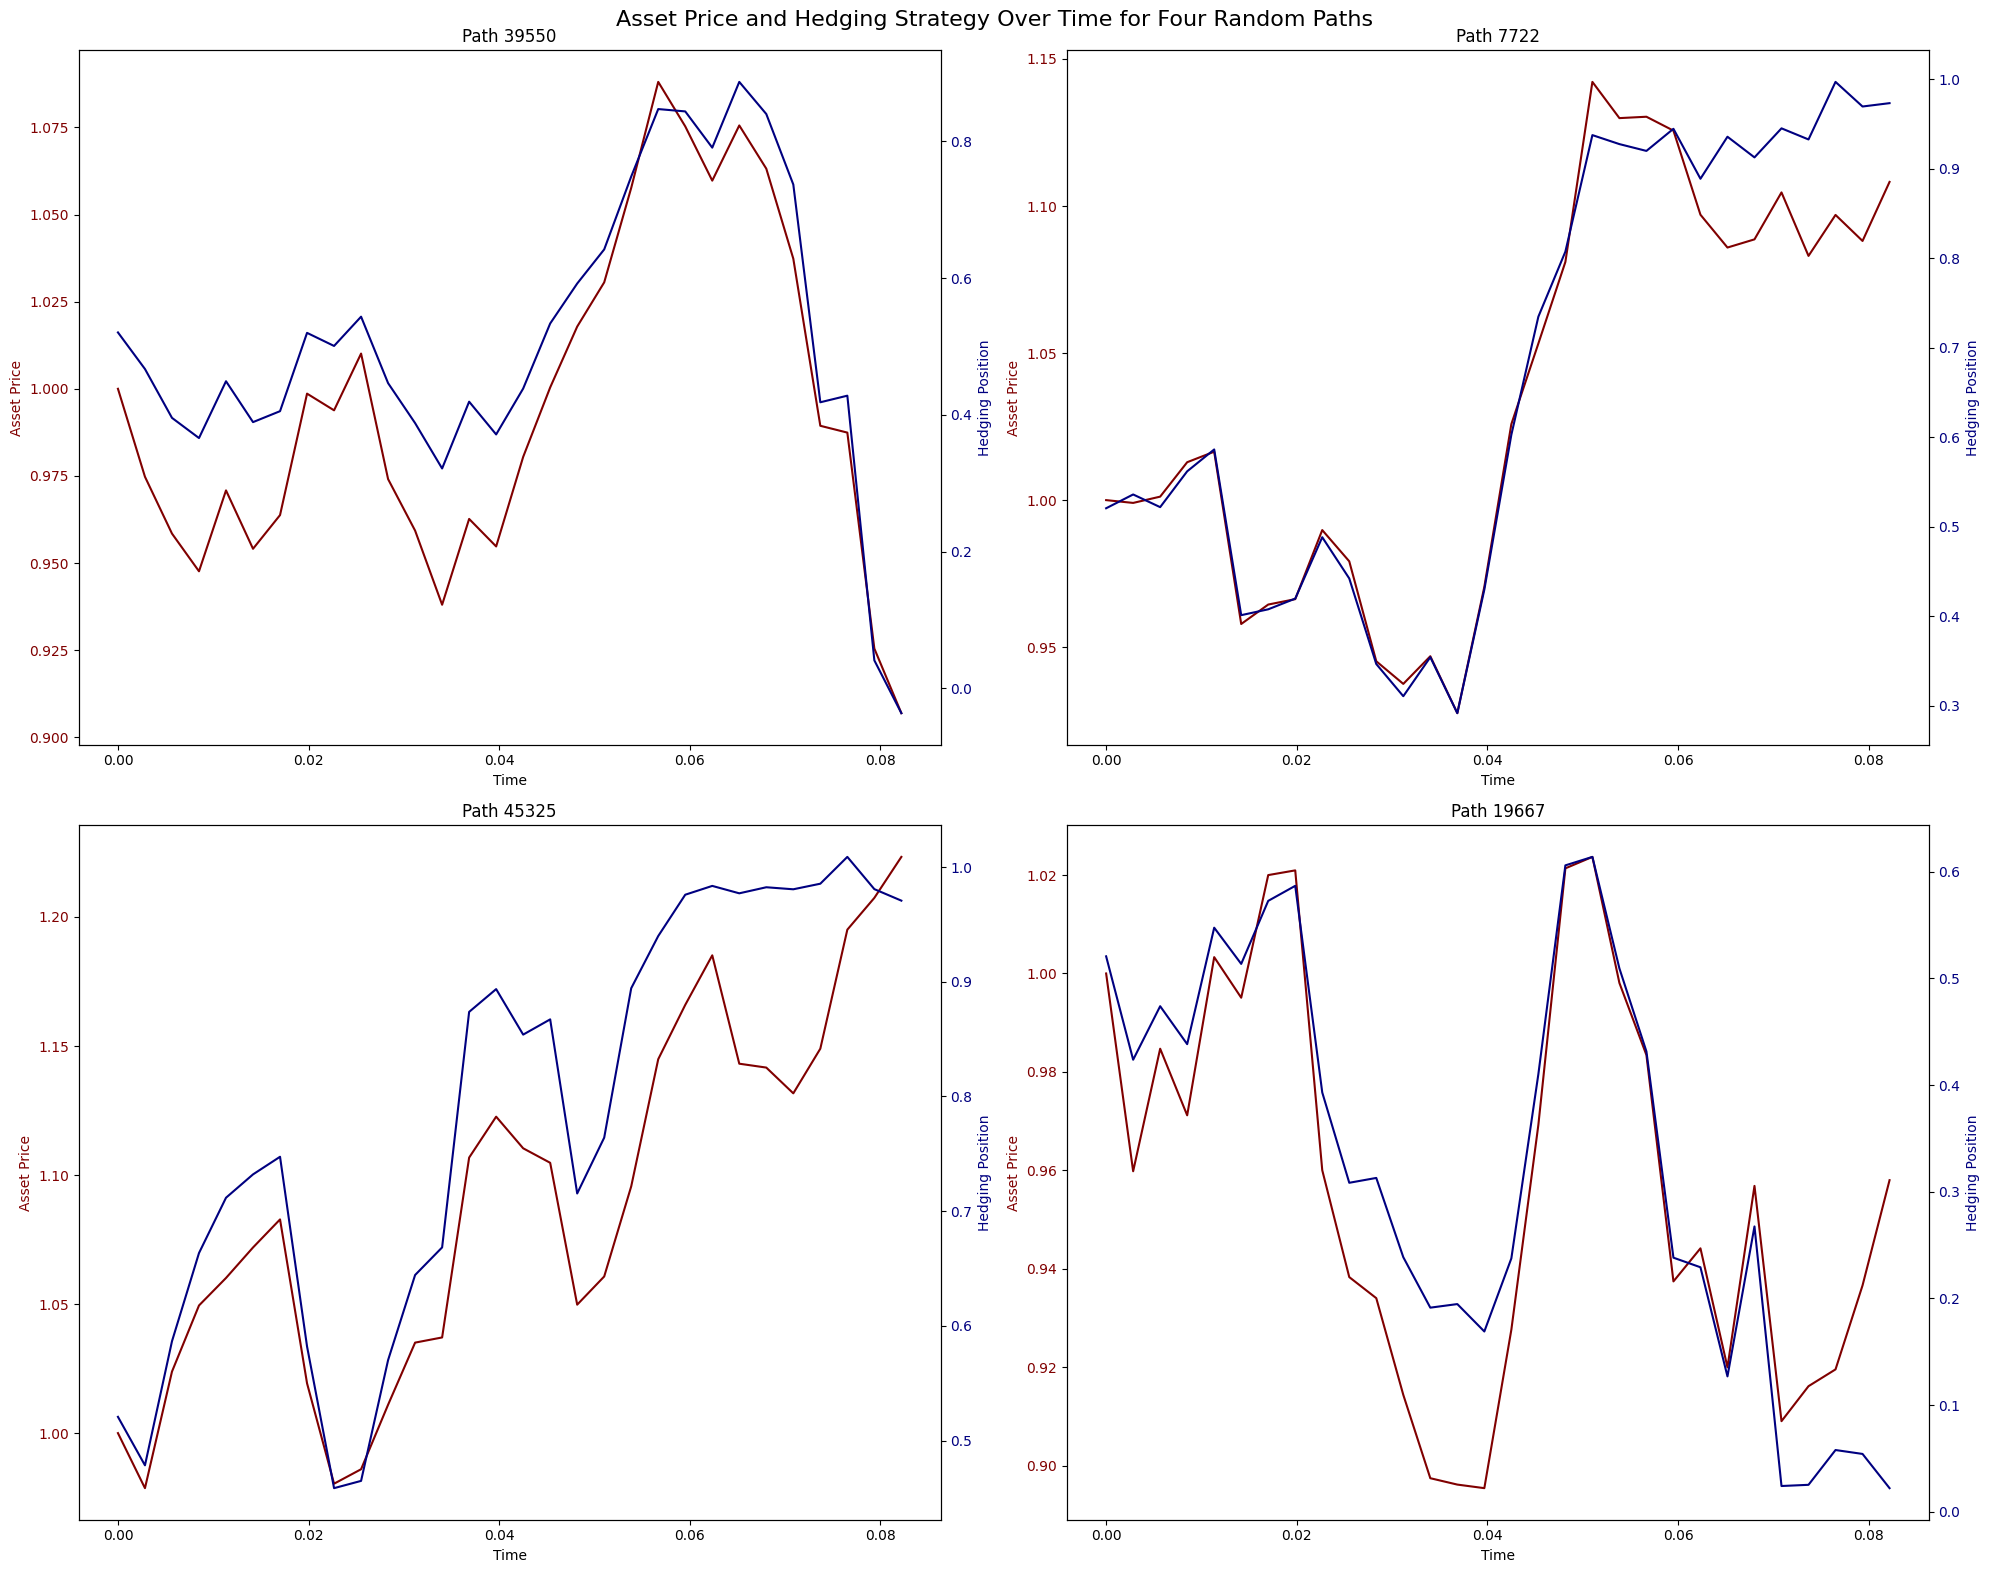

In [20]:
"""
In order to understand the hedging strategy better, we visualize the asset 
price and the hedging strategy for four  path from the test set.
"""
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Asset Price and Hedging Strategy Over Time for Four Random Paths', fontsize=16)
time_points = np.linspace(0, T, N)

model.eval()
with torch.no_grad():
    for i, ax in enumerate(axs.flatten()):
        # Choose a random path
        path_idx = np.random.randint(num_test)
        # Get the asset price
        single_path = S_test_tensor[path_idx].unsqueeze(0).to(device)
        # Predict the hedging strategy for this path
        H_single = model(single_path).squeeze().cpu().numpy()

        # Plot the asset price
        color = 'maroon'
        ax.set_xlabel('Time')
        ax.set_ylabel('Asset Price', color=color)
        line1, = ax.plot(time_points, S_test_tensor[path_idx].numpy()[:-1], color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create second y-axis for the hedging strategy
        ax2 = ax.twinx()
        color = 'navy'
        ax2.set_ylabel('Hedging Position', color=color)
        line2, = ax2.plot(time_points, H_single, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        ax.set_title(f'Path {path_idx+1}')

plt.tight_layout()
plt.savefig('plots/hedging_strategy_multiple_paths.pdf')
plt.show()

A few questions for you to consider...

Have you trained your model well?
- Are the losses centered on zero?
- Is their standard deviation sufficiently small?

How can you improve performance?
- train for more epochs
- try different batch sizes
- try a different learning rate
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function
- change the networks' architectures (more/less hidden neurons, more/less hidden layers)
- reduce/increase the learning rate
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

# Exercise 2

### Question 2.a - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy:

We know that $C(S_t=s, t) = \Phi(d_+) S_t - \Phi(d_-) K e^{r(T - t)}$ where $d_+ = \frac{1}{\sigma \sqrt{T - t}} \left( \log \left( \frac{S_t}{K} \right) + \left( r + \frac{\sigma^2}{2} \right)(T - t) \right)$ and $d_- = d_+ - \sigma \sqrt{T - t}$.


We now find the optimal hedging strategy $H^{\text{BS}}_t(s) = \frac{\partial C(S_t=s, t)}{\partial s}$:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(S_t=s, t)}{\partial s} \\
& = \frac{\Phi(d_+) s - \Phi(d_-) K e^{r(T - t)}}{\partial s} \\
& = \frac{\Phi(d_+) s}{\partial s} - \frac{\Phi(d_-) K e^{r(T - t)}}{\partial s} \\
& = \Phi(d_+) + s \frac{\partial \Phi(d_+)}{\partial s} - K e^{r(T - t)} \frac{\partial \Phi(d_-)}{\partial s} \\
& = \Phi(d_+) + s \frac{\partial \Phi(d_+)}{\partial d_+} \frac{\partial d_+}{\partial s} - K e^{r(T - t)} \frac{\partial \Phi(d_-)}{\partial d_-} \frac{\partial d_-}{\partial s} \quad \text{(Chain rule)}\\
& = \Phi(d_+) + s \phi(d_+) \frac{\partial d_+}{\partial s} - K e^{r(T - t)} \phi(d_-) \frac{\partial d_-}{\partial s} \\
& = \Phi(d_+) + s \phi(d_+) \frac{\partial}{\partial s} \left( \frac{1}{\sigma \sqrt{T - t}} \left( \log \left( \frac{s}{K} \right) + \left( r + \frac{\sigma^2}{2} \right)(T - t) \right) \right) - K e^{r(T - t)} \phi(d_-) \frac{\partial}{\partial s} \left( \frac{1}{\sigma \sqrt{T - t}} \left( \log \left( \frac{s}{K} \right) + \left( r + \frac{\sigma^2}{2} \right)(T - t) \right) - \sigma \sqrt{T - t} \right) \\
& = \Phi(d_+) + \cancel{s} \phi(d_+) \frac{1}{\sigma \sqrt{T - t}} \frac{1}{\cancel{s}} - K e^{r(T - t)} \phi(d_-) \frac{1}{\sigma \sqrt{T - t}} \frac{1}{s} \\
& = \Phi(d_+) + \frac{1}{\sigma \sqrt{T - t}} \phi(d_+) - \frac{K e^{r(T - t)}}{\sigma \sqrt{T - t}} \phi(d_-) \frac{1}{s} \\

\end{align*}

Here $\phi(\cdot)$ is the PDF of the standard Gaussian Distribution.

### Question 2.b - Analytical solution evaluation

In [21]:
# Implement the formula you found

def analytical_solution(s, K, T, t, r, sigma):
    """Implements the analytical formula for the hedging strategy."""
    d_plus = (np.log(s / K) + (r + sigma**2 / 2)*(T - t)) / (sigma * np.sqrt(T - t))
    d_minus = d_plus - sigma * np.sqrt(T - t)
    return norm.cdf(d_plus) + (1 / (sigma * np.sqrt(T - t)) * norm.pdf(d_plus)) - (K * np.exp(r * (T - t)) / (sigma * np.sqrt(T - t))) * norm.pdf(d_minus) * (1/s)



# Evaluate the losses of the analytical hedging strategies on the test set

analytical_hedging_errors = []
K =1
r=0

for path in tqdm(S_test):
    hedging_cost = 0
    for j in range(N):
        t_j = j * T/N   # Time at step j
        H_analytical = analytical_solution(path[j], K=K, T=T, t=t_j, r=r, sigma=sigma)
        hedging_cost += H_analytical * (path[j+1] - path[j])
    
    payoff = max(path[-1] - K, 0) # Payoff of the option at maturity (i.e., g(S_T))
    hedging_error = payoff - p - hedging_cost   # Hedging portfolio losses at maturity
    analytical_hedging_errors.append(hedging_error)

# Print statistics for analytical solution
mean_analytical = np.mean(analytical_hedging_errors)
std_analytical = np.std(analytical_hedging_errors)
print(f"\nAnalytical Strategy:")
print(f"Empirical Mean of Hedging Errors: {mean_analytical:.6f}")
print(f"Empirical Standard Deviation of Hedging Errors: {std_analytical:.6f}")


100%|██████████| 100000/100000 [38:55<00:00, 42.82it/s]



Analytical Strategy:
Empirical Mean of Hedging Errors: -0.000012
Empirical Standard Deviation of Hedging Errors: 0.008922


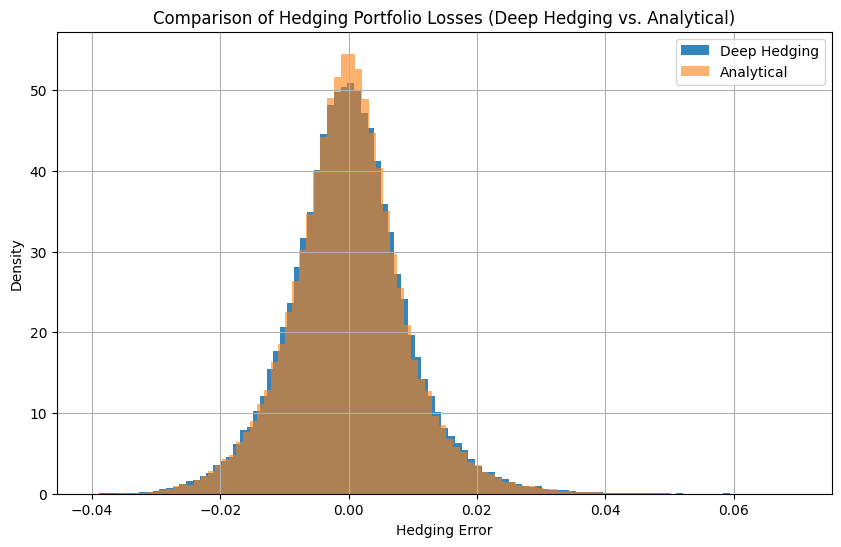

In [22]:
# Compare histograms
plt.figure(figsize=(10, 6))
plt.hist(hedging_errors, bins=100, alpha=0.9, label='Deep Hedging', density=True)
plt.hist(analytical_hedging_errors, bins=100, alpha=0.6, label='Analytical', density=True)
plt.title('Comparison of Hedging Portfolio Losses (Deep Hedging vs. Analytical)')
plt.xlabel('Hedging Error')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig('plots/comparison_hedging_errors_deep_vs_analytical.pdf')
plt.show()

**Something to think about**: in the Black-Scholes model every option can be perfectly hedged using its analytical hedging strategy.
But the analytical solution you have computed does not give zero losses. Can you explain why?

**COMMENT**: The analytical solution only gives 0 loss in the continous scenario. However, we hedge in discrete time steps, which leads to a non-zero loss.

### Question 2.c - Hedging losses comparison

How does your deep hedging model compare with the analytical solution?
- If it's worse, you must improve its performance (see checklist above)

### Question 2.d - Learned strategy comparison

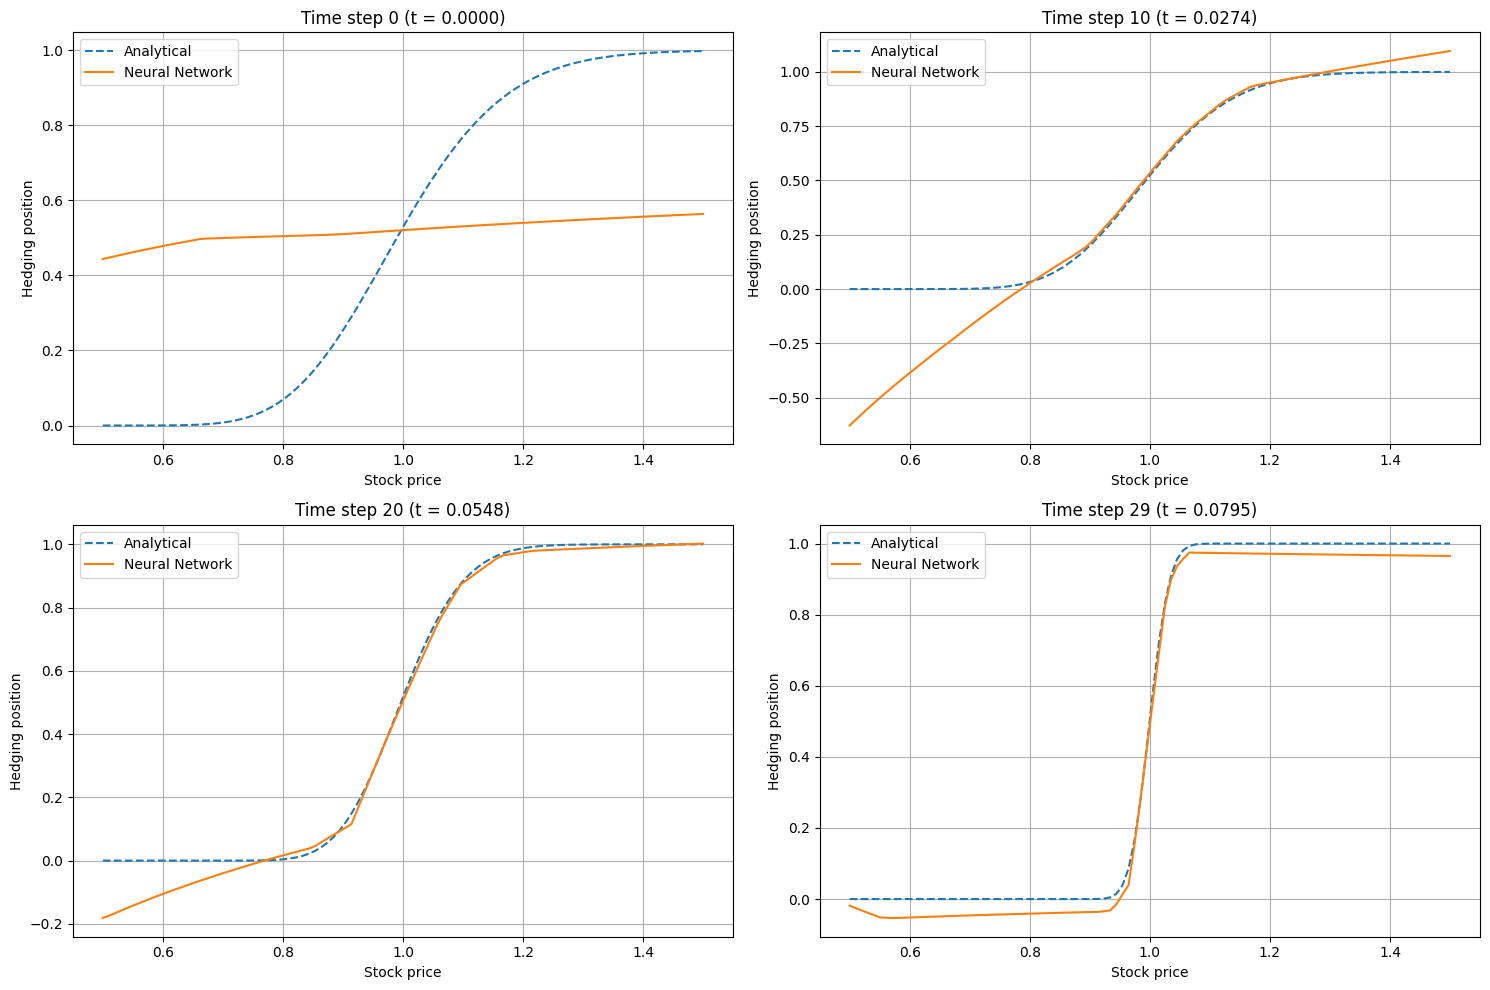

In [23]:
# Plot both the neural network strategies and the analytical hedging strategies

times_to_compare = [0, 10, 20, 29]
s_range = np.linspace(0.5, 1.5, 100)

plt.figure(figsize=(15, 10))

for idx, j in enumerate(times_to_compare):
    t_j = j * T/N   # Time at step j
    
    # Compute analytical solution
    H_analytical = [analytical_solution(s, K=1, T=T, t=t_j, r=r, sigma=sigma) for s in s_range]
    
    # Compute neural network solution
    model.eval()
    with torch.no_grad():
        log_s = torch.tensor(np.log(s_range), dtype=torch.float32).unsqueeze(1).to(device)
        H_neural = model.hedging_networks[j](log_s).detach().numpy()
    
    plt.subplot(2, 2, idx+1)
    plt.plot(s_range, H_analytical, label='Analytical', linestyle='--')
    plt.plot(s_range, H_neural, label='Neural Network')
    plt.title(f'Time step {j} (t = {t_j:.4f})')
    plt.xlabel('Stock price')
    plt.ylabel('Hedging position')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('plots/comparison_strategies_deep_vs_analytical.pdf')
plt.show()

- For what times $t_j$ are the two functions most similar? 
- Why?

**COMMENT:**
- The Deep Hedging Neural Network and analytical solutions become increasingly similar as we approach maturity (from $t_0$ to $t_29$).
- This makes absolute sense, as there's less uncertainty about the final payoff as we approach the maturity $T$.

# Exercise 3

### Question 3.a - Model implementation

In [24]:
# Implement the new deep hedging model

class SingleNetworkHedgingModel(nn.Module):
    """New deep hedging model with a single neural network, by using time as an additional feature."""
    def __init__(self, hidden_size=32):
        super(SingleNetworkHedgingModel, self).__init__()
        self.neural_network = nn.Sequential(
            nn.Linear(2, hidden_size),  # 2 inputs: sqrt(T-t) and log(S_t)
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, S_paths):
        """
        Compute the hedging strategies for each time step.
        """
        H = []
        for j in range(N):
            t_j = j * T/N
            # Create inputs: sqrt(T-t) and log(S_tj)
            time_to_maturity = torch.full((S_paths.shape[0], 1), np.sqrt(T - t_j)).to(device)
            log_S_tj = torch.log(S_paths[:, j]).unsqueeze(1)
            x = torch.cat([time_to_maturity, log_S_tj], dim=1)
            H_j = self.neural_network(x)
            H.append(H_j.squeeze(1))
        
        # Stack the hedging strategies along the time dimension
        H = torch.stack(H, dim=1)   # Shape: (num_paths, number_of_time_steps)
        return H

### Question 3.b - Model training

100%|██████████| 5/5 [13:33<00:00, 162.73s/it, loss=8.13e-5] 


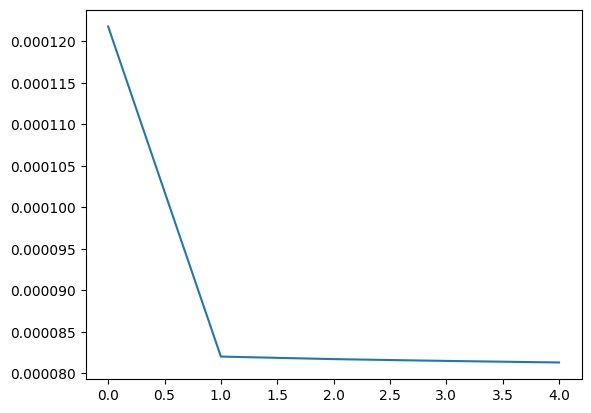

In [26]:
# Train the new deep hedging model
learning_rate = 1e-3
milestones = [75]
single_model = SingleNetworkHedgingModel().to(device)
optimizer = optim.Adam(single_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
NUM_EPOCHS = 5
BATCH_SIZE = 128

losses = []

start_time = time.time()

single_model.train()
training_loop = tqdm(range(NUM_EPOCHS))
for epoch in training_loop:
    epoch_loss = 0.0
    for batch_idx, batch in enumerate(train_loader): # Number of batches = num_train / BATCH_SIZE
        S_batch = batch[0].to(device) # Shape: (batch_size, N+1)
        
        # Forward pass: Compute hedging strategies H
        H = single_model(S_batch)
        
        # Compute delta_S: S_{t_{j+1}} - S_{t_j}
        delta_S = S_batch[:, 1:] - S_batch[:, :-1]
        
        # Compute hedging cost: sum_j H_{t_j} * delta_S_{t_j}
        hedging_cost = torch.sum(H * delta_S, dim=1)
        
        # Compute the option payoff g(S_T)
        g_of_S_T = call_option_payoff(S_T=S_batch[:, -1], K=1)
        
        # Compute hedging error (i.e., the loss)
        tmp = torch.square(g_of_S_T - p - hedging_cost)
        hedging_error = torch.mean(tmp)
        
        # Backward pass and optimization
        hedging_error.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += torch.sum(tmp).detach().item()
    
    scheduler.step()
    
    avg_epoch_loss = epoch_loss / num_train
    losses.append(avg_epoch_loss)
    training_loop.set_postfix(loss=avg_epoch_loss)

training_time_single = time.time() - start_time

# Plot the training loss
plt.plot(losses, label='Training loss')
plt.show()

### Question 3.c - Model evaluation


Comparison of Models:
Original Deep Hedging Model:
Mean of Hedging Errors: -0.000012
Standard Deviation of Hedging Errors: 0.009144

Single Network Model:
Mean of Hedging Errors: -0.000011
Standard Deviation of Hedging Errors: 0.008951


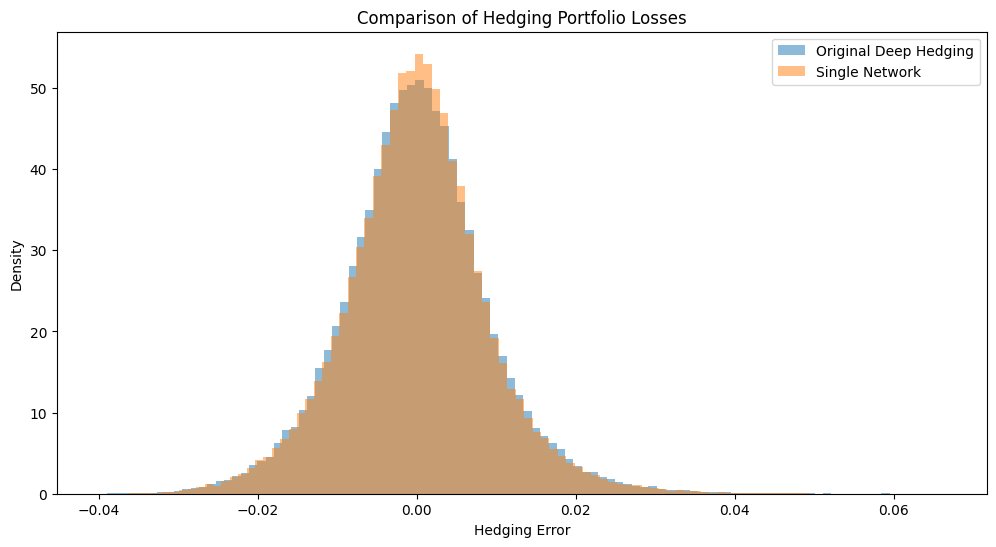

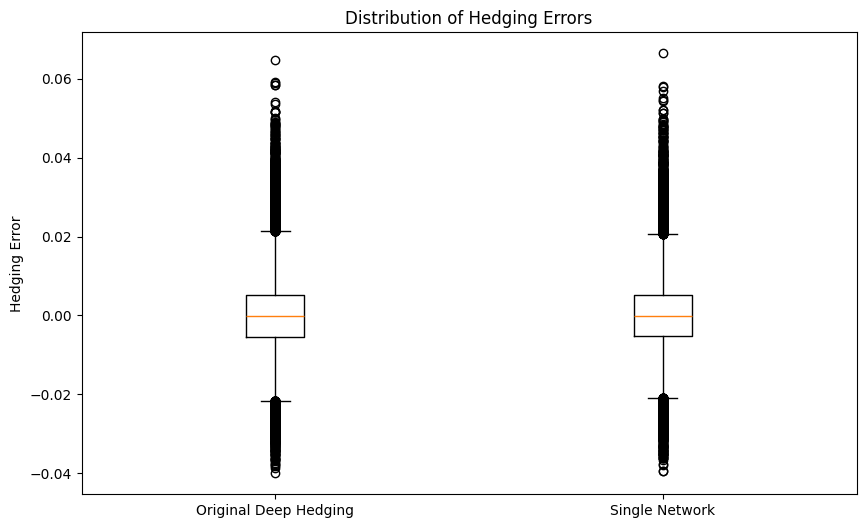

In [27]:
# Evaluate the hedging losses on the test set
single_model.eval()
single_hedging_errors = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        S_batch = batch[0].to(device)
        
        # Compute hedging strategies
        H = single_model(S_batch)
        
        # Compute delta_S
        delta_S = S_batch[:, 1:] - S_batch[:, :-1]
        
        # Compute hedging cost
        hedging_cost = torch.sum(H * delta_S, dim=1)
        
        # Compute option payoff
        g_of_S_T = call_option_payoff(S_T=S_batch[:, -1], K=1)
        
        # Compute hedging error
        hedging_error = g_of_S_T - p - hedging_cost
        single_hedging_errors.extend(hedging_error.detach().numpy())


# Calculate statistics
single_mean = np.mean(single_hedging_errors)
single_std = np.std(single_hedging_errors)
print("\nComparison of Models:")
print(f"Original Deep Hedging Model:")
print(f"Mean of Hedging Errors: {mean_error:.6f}")
print(f"Standard Deviation of Hedging Errors: {std_error:.6f}")
print(f"\nSingle Network Model:")
print(f"Mean of Hedging Errors: {single_mean:.6f}")
print(f"Standard Deviation of Hedging Errors: {single_std:.6f}")

# Plot a histogram of the hedging losses and print mean and standard deviation
plt.figure(figsize=(12, 6))
plt.hist(hedging_errors, bins=100, alpha=0.5, label='Original Deep Hedging', density=True)
plt.hist(single_hedging_errors, bins=100, alpha=0.5, label='Single Network', density=True)
plt.title('Comparison of Hedging Portfolio Losses')
plt.xlabel('Hedging Error')
plt.ylabel('Density')
plt.legend()
plt.savefig('plots/comparison_hedging_errors_models.pdf')
plt.show()

# Boxplot of the hedging errors
plt.figure(figsize=(10, 6))
plt.boxplot([hedging_errors, single_hedging_errors], labels=['Original Deep Hedging', 'Single Network'])
plt.title('Distribution of Hedging Errors')
plt.ylabel('Hedging Error')
plt.savefig('plots/boxplot_comparison_models.pdf')
plt.show()

### Question 3.d - Model comparison

In [28]:
# Compare with the first deep hedging model (Exercise 1)
# Keep the comparison fair: evaluate run-time, performance and number of parameters.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

original_params = count_parameters(model)  # assuming 'model' is your original model
single_params = count_parameters(single_model)

print(f"\nNumber of Parameters:")
print(f"Original Model: {original_params}")
print(f"Single Network Model: {single_params}")

# Compare run-time
print(f"\nTraining Time:")
print(f"Original Model: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Single Network Model: {training_time_single:.2f} seconds ({training_time_single/60:.2f} minutes)")



Number of Parameters:
Original Model: 2910
Single Network Model: 1185

Training Time:
Original Model: 1797.93 seconds (29.97 minutes)
Single Network Model: 813.66 seconds (13.56 minutes)


**COMMENT:**
- We cann see that the single network deep hedging model performs similar to the original model (we even achieve a slightly lower standard deviation of hedging errors (0.00898 vs 0.00915) and with the same mean error (-0.00001)). 
- However, this performance is achieved with less than half the number of parameters (1,185 vs 2,910) and half the training time!
- Conclusion: Since we can obtain the same performance with fewer parameters and less training time, using time as an extra feature in a single network is a more effective architectural decision than using different networks for every time step.